In [1]:
import numpy as np
from numpy.random import default_rng
rng = default_rng(1)
import matplotlib.pyplot as plt

!pip install colorednoise

### Sample Parameters
Specify the sampling rate (fs), total time of the signal (total_time). This calculates the number of timesteps and the value of each timestep

In [2]:
fs = 1000  # 1 kHz
total_time = 10000  # 10 seconds or 10000 milliseconds

samples = 1 * total_time
t = np.linspace(0, total_time/1000, samples)

### Noise Generator
Using the colored noise library, pink noise is with beta = 1. This shape should match the number of timesteps.

In [3]:
import colorednoise as cn

beta = 1  # pink noise is 1
noise = cn.powerlaw_psd_gaussian(beta, samples)
print(noise.shape)

(10000,)


### Calculate Threshold

We calculate the positive threshold for signifying a burst in the noise. This is done via a 1 \* Z-Score of the hilbert transformed noise.

In [4]:
from scipy import signal

noise_amp = abs(signal.hilbert(noise))
threshold = np.mean(noise_amp) + (1 * np.std(noise_amp))

### Buried Synthetic Signals

Below we create buried signals. The first is the sine wave, second is the Gabor Atom (gausspulse in scipy). The Gaussian Pulse center amplitudes are scaled via a uniform random generator.

1.94668734194267


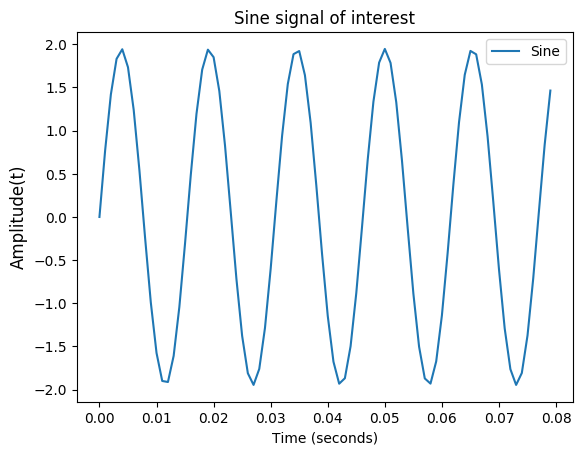

In [5]:
amplitude = threshold
print(amplitude)
frequency = 65  # 65 Hz


# sin_amp = rng.uniform(low=threshold, high=threshold+0.5, size=t.shape)
sine = amplitude * np.sin(frequency * 2 * np.pi * t)
plt.plot(t[:80], sine[:80], label='Sine')
plt.title('Sine signal of interest')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
# plt.xlim(1,samples)
plt.legend()
plt.show()

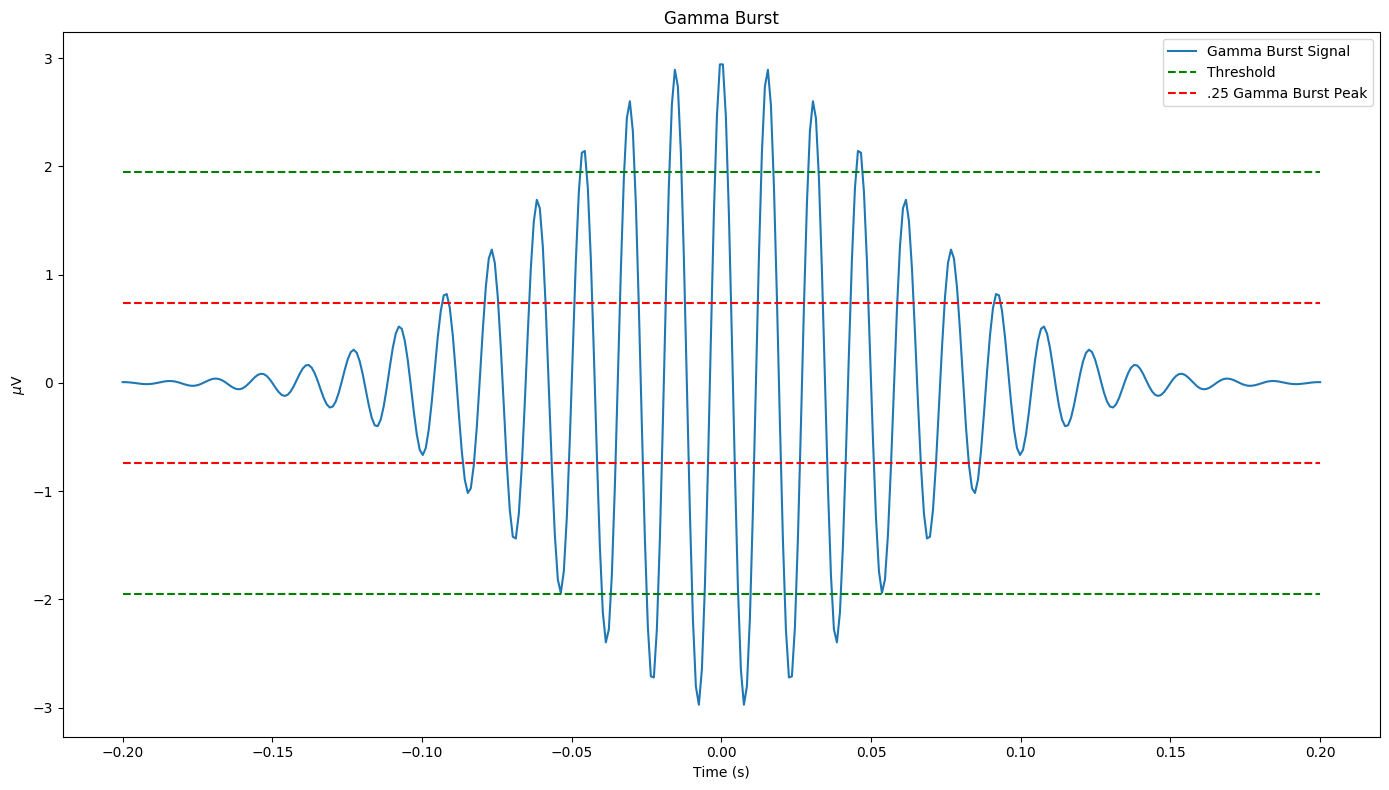

In [6]:
gp_t = np.linspace(-.2, .2, 400)

plt.figure(figsize=(14,8))
yl = rng.uniform(low=2.75, high=3.25) * signal.gausspulse(gp_t, fc=65, bw=0.1)  # bw = [.1, .6]
bt = .25 * np.max(yl)
plt.plot(gp_t, yl, label='Gamma Burst Signal')
plt.plot(gp_t, [threshold for _ in range(gp_t.shape[0])], 'g--', label='Threshold')
plt.plot(gp_t, [bt for _ in range(gp_t.shape[0])], 'r--', label='.25 Gamma Burst Peak')
plt.plot(gp_t, [-threshold for _ in range(gp_t.shape[0])], 'g--')
plt.plot(gp_t, [-bt for _ in range(gp_t.shape[0])], 'r--')
plt.title('Gamma Burst')
plt.xlabel('Time (s)')
plt.ylabel(r'$\mu$V')
plt.legend()
plt.tight_layout()
plt.show()

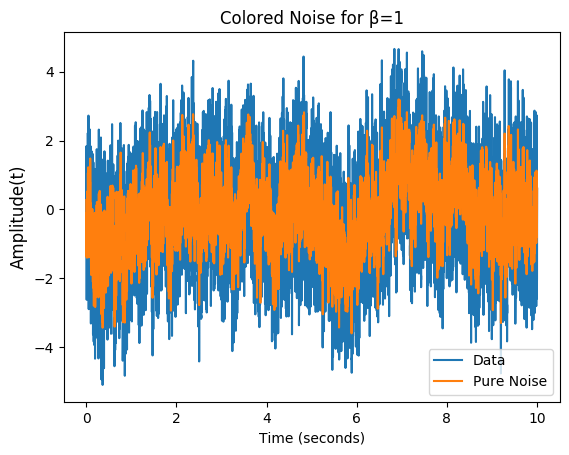

In [7]:
plt.plot(t, noise+sine, label='Data')
plt.plot(t, noise, label='Pure Noise')
plt.title('Colored Noise for β='+str(beta))
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude(t)', fontsize='large')
plt.legend()
plt.show()

### Modeled Data

The modeled data is loaded in and the locations of gamma bursts are found. It builds a list of burst inputs to draw from.

In [8]:
FENG_LFP_PATH = '/home/matt/data/InVivoLFPs/FengData/LFP_elec_combine.txt'
FENG_ITN_PATH = '/home/matt/data/InVivoLFPs/FengData/FR_PN_ITN.txt'

from lfp_prediction.data_gathering import TextCollector

frequency_band = (60, 70)

if 'dc' in locals():  # This is done to delete the massive variables and free up some space before attempting to use more
    del dc
dc = TextCollector(FENG_LFP_PATH)
lfp = dc.get_data(column=None)
dc = TextCollector(FENG_ITN_PATH)
itn = dc.get_data(column=2)

del dc

fs = 1000
z, a = signal.butter(4, frequency_band, btype='bandpass', output='ba', fs=fs)
filtered_data = signal.filtfilt(z, a, lfp, axis=0)

LFP_amp = abs(signal.hilbert(filtered_data))
threshold = np.mean(LFP_amp) + (1 * np.std(LFP_amp))

"""
Find the gamma burst indices in the filtered data and mark as 1
"""
indices = np.argwhere(abs(filtered_data) > threshold)
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[indices] = 1

change_idxs = np.diff(lfp_mask, axis=0)
ones = np.argwhere(change_idxs == 1)[:,0]
n_ones = np.argwhere(change_idxs == -1)[:,0]
lfp_mask = np.zeros(filtered_data.shape)
lfp_mask[ones] = 1
lfp_mask[n_ones] = -1

gaps = np.diff(ones, axis=0)
n_gaps = np.diff(n_ones, axis=0)

lfp_gap = np.diff(lfp_mask, axis=0)

ones_idxs = np.argwhere(gaps > 28)[:,0]
n_ones_idxs = np.argwhere(n_gaps > 28)[:,0]
lfp_mask_2 = np.zeros(filtered_data.shape)

full_index_list = np.arange(filtered_data.shape[0])

"""
Build list of gamma burst indices
"""
combo_idxs = np.sort(np.concatenate((ones[ones_idxs], n_ones[n_ones_idxs])), axis=0)
combo_idxs = np.insert(combo_idxs, 0, [0])
combo_idxs = np.append(combo_idxs, filtered_data.shape[0]-1)
print(combo_idxs)

# list_of_bursts = np.split(filtered_data[:,0], combo_idxs.astype(int).tolist())

list_of_bursts = []
i = 0
while i < combo_idxs.shape[0]-1:
    list_of_bursts.append(filtered_data[combo_idxs[i]:combo_idxs[i+1],0])
    i += 2


lob = []
for i, l in enumerate(list_of_bursts):
    m = np.max(l)
    if m < threshold:
        continue
    else:
        # print(i, m, threshold)
        qm = .25 * m
        si = np.argmax(l>qm)
        ei = len(l) - np.argmax(l[::-1]>qm)
        if ei - si < 20:
            continue
        lob.append(l[si:ei])

        
"""
Build a list of bursts containing 400 ms (200 for input/200 for output) centered around the gamma burst.
This ensures part of the gamma burst is in the input and part is in the output.
"""
fixed_bursts = []
for l in lob:
    if l.shape[0] < 400:
        pad_needed = 400 - l.shape[0]
        front_pad = int(pad_needed/2)
        back_pad = pad_needed - front_pad
        fixed_bursts.append(np.pad(l, pad_width=(front_pad, back_pad), mode='reflect'))
    elif l.shape[0] > 400:
        center_idx = int(l.shape[0] / 2)
        fixed_bursts.append(l[center_idx-200:center_idx+200])
fixed_burst_sizes = np.stack(fixed_bursts)
print(fixed_burst_sizes.shape)

[      0     145     147 ... 2999589 2999590 3000000]
(6285, 400)


### Generate Dataset
This is the standard dataset generation. In the for loop, one must specify the determinstic data and labels in the first if condition and the noise data and labels in the else condition. The determinstic data and labels can be either model or synthetic depending on what is specified.

In [9]:
sin_len = 400

z, a = signal.butter(4, [55, 85], btype='bandpass', output='ba', fs=fs)
# filtered_data = signal.filtfilt(z, a, noise + sine, axis=0)

data = []
labels = []
bursts = []
num_samples = 7500

padding_len = 30
padding = np.zeros(padding_len)
for i in range(num_samples):
    bw = rng.uniform(low=0.1, high=0.6)
    bursts.append(np.concatenate((padding, (rng.uniform(low=2.75, high=3.25) * signal.gausspulse(gp_t, fc=65, bw=bw)))))
    # bursts.append(np.concatenate((padding, (3 * signal.gausspulse(gp_t, fc=65, bw=bw)))))
    # bursts.append(np.concatenate((padding, (3 * signal.gausspulse(gp_t, fc=65, bw=0.35)))))
bursts = np.stack(bursts)
print(bursts.shape)

indices = rng.choice(noise.shape[0] - sin_len, num_samples, replace=False)
inc_sin = rng.choice([0, 1], size=num_samples, replace=True)
inc_bur = rng.choice(np.arange(padding_len), size=num_samples, replace=True)
inc_feng_bur = rng.choice(np.arange(fixed_burst_sizes.shape[0]), size=num_samples, replace=True)
for i, idx in enumerate(indices):
    if inc_sin[i] == 1:
        # filtered_data = signal.filtfilt(z, a,
        #                                 noise[idx:idx+int(sin_len)] + sine[idx:idx+int(sin_len)],
        #                                 axis=0)
        # data.append(filtered_data[:int(sin_len/2)])
        # labels.append(filtered_data[int(sin_len/2):])
        data.append(noise[idx:idx+int(sin_len/2)] + sine[idx:idx+int(sin_len/2)])
        # data.append(noise[idx:idx+int(sin_len/2)] + bursts[i, inc_bur[i]:inc_bur[i] + int(sin_len/2)])

        # labels.append(noise[idx+200:idx+400] + sine[idx:idx+200])
        labels.append(sine[idx+int(sin_len/2):idx+sin_len])
        # filtered_data = signal.filtfilt(z, a,
        #                                 noise[idx+int(sin_len/2):idx+int(sin_len)] + bursts[i, inc_bur[i] + int(sin_len/2):inc_bur[i] + int(sin_len)],
        #                                 axis=0)
        # labels.append(filtered_data)
        # data.append(fixed_burst_sizes[inc_feng_bur[i],:200])
        # labels.append(fixed_burst_sizes[inc_feng_bur[i],200:])
        # labels.append(bursts[i, inc_bur[i] + int(sin_len/2):inc_bur[i] + int(sin_len)])
    else:
        filtered_data = signal.filtfilt(z, a, noise[idx:idx+int(sin_len/2)], axis=0)
        data.append(filtered_data)
        filtered_data = signal.filtfilt(z, a, noise[idx+int(sin_len/2):idx+int(sin_len)], axis=0)
        # labels.append(np.zeros(int(sin_len/2)))
        labels.append(filtered_data)



data = np.stack(data).reshape((num_samples, 1, -1))
labels = np.stack(labels).reshape((num_samples, 1, -1))
print(data.shape)
print(labels.shape)

(7500, 430)
(7500, 1, 200)
(7500, 1, 200)


In [10]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

5625
(7500, 1, 200)
(7500, 1, 200)


<Figure size 1000x1000 with 0 Axes>

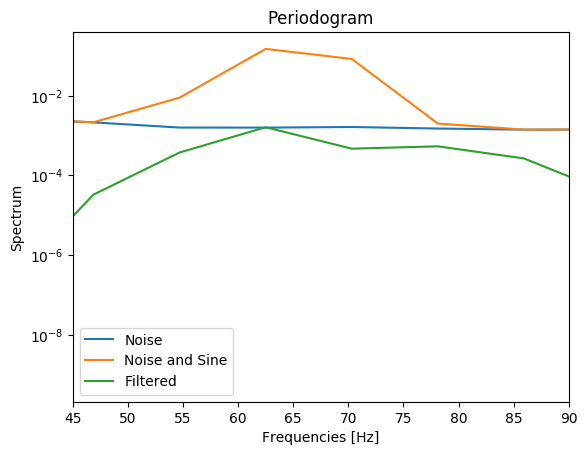

In [11]:
from scipy.signal import welch

plt.figure(figsize=(10, 10))

axs = plt.subplots()

f_n, psd_n = welch(noise, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_ns, psd_ns = welch(noise+sine, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
f_f, psd_f = welch(filtered_data, fs=fs, window='hamming', nperseg=128, scaling='density', axis=0)
plt.semilogy(f_n, psd_n, label='Noise')
plt.semilogy(f_ns, psd_ns, label='Noise and Sine')
plt.semilogy(f_f, psd_f, label='Filtered')
# plt.ylim([1e-3, 1e-1])
plt.xlim([45, 90])
plt.xlabel('Frequencies [Hz]')
plt.ylabel('Spectrum')
plt.title('Periodogram')
plt.legend()
plt.show()

In [12]:
import torch
import torch.nn as nn

class FullyConnected(nn.Module):
    def __init__(self,
                 in_size: int = 200,
                 out_size: int = 200):
        super(FullyConnected, self).__init__()
        self.fcn = nn.Sequential(
            nn.Linear(in_size, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 200)
        )

    def forward(self, x):
        return self.fcn(x)


class LSTM(nn.Module):
    def __init__(self, in_size: int = 1,
                 h_size: int = 200,
                 out_size: int = 200,
                 num_layers: int = 1,
                 batch_first: bool = True,
                 dropout: float = 0.0,
                 bidirectional: bool = False) -> None:
        super(LSTM, self).__init__()
        self.rnn = nn.LSTM(input_size=in_size,
                           hidden_size=h_size,
                           num_layers=num_layers,
                           batch_first=batch_first,
                           dropout=dropout,
                           bidirectional=bidirectional)
        self.lin = nn.Linear(h_size, out_size)

    def forward(self, x):
        x = torch.transpose(x, 1, 2)  # RNN variants expect (N, L, H)
        x, (_, _) = self.rnn(x)  # Returns (N, L, hidden_size)
        # return x[:, -1, :]
        out = self.lin(x[:, -1, :])  # Feeds hidden stats of last cell to FCN
        return out

In [13]:
from typing import Optional, Tuple, List
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


def fit(model: nn.Module,
        training_loader: DataLoader,
        validation_loader: DataLoader,
        epochs: int = 50,
        device: str = 'cpu',
        write_losses: bool = False,
        save_filepath: Optional[str] = None,
        **kwargs) -> Tuple[List, List]:
    """
    Function used to fit the specified model with the provided data
    :param model: neural network pytorch model
    :param training_loader: pytorch dataloader containing the training data
    :param validation_loader: pytorch dataloader containing the validation data
    :param epochs: number of epochs to train
    :param device: which device to train the model on. Should be either "cuda:0" or "cpu"
    :param write_losses: boolean flag as to report losses during training
    :param save_filepath: path to save model, if not specified, no model is saved
    :param kwargs: "optim" optimizer,
                    "loss_function" loss function,
                    "decay_rate" decay rate,
                    "model_save_path" model save path,
                    "loss_save_path" csv save path
    :return: training and validation losses over each epoch
    """
    train_loss_list = []
    val_loss_list = []

    # splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01) if 'optim' not in kwargs else kwargs.get('optim')

    loss_func = nn.MSELoss() if 'loss_function' not in kwargs else kwargs.get('loss_function')

    decay_rate = .99995 if 'decay_rate' not in kwargs else kwargs.get('decay_rate')
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)

    temp_loss = 100000000000000.0

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                x = x.to(device)
                output = model(x)
                y = y.to(device)
                loss = loss_func(torch.squeeze(output), torch.squeeze(y))

                # backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # calculating total loss
                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
            else:
                val_loss = running_loss

        # shows total loss
        if epoch % 10 == 0 and write_losses:
            tqdm.write('{} train loss: {.6f} val loss: {.6f}'.format(epoch + 1, train_loss, val_loss))

        # saving best model
        if train_loss < temp_loss and save_filepath:
            torch.save(model, save_filepath)
            temp_loss = train_loss

        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)


    return train_loss_list, val_loss_list

In [14]:
import copy

epochs = 50
model = LSTM(bidirectional=False)
# model = FullyConnected()
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = fit(model, train_data, valid_data, epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

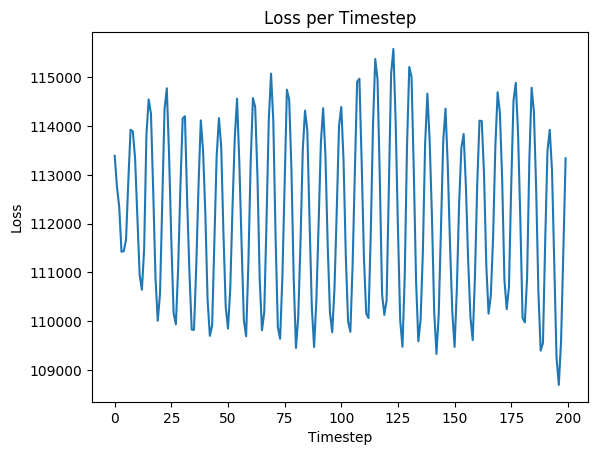

In [15]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:
    losses = {i:0 for i in range(0, labels.shape[2], 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        for t in range(0, labels.shape[2], 1):
            y_true = y[:,:,t]
            y_pred = output[:,t]
            squared_error = ((y_true - y_pred) ** 2)
            # print(squared_error.shape)
            losses[t] += np.sum(squared_error)
    #  TODO Losses normalized by std of each timestep
    return losses


losses = validate_model(model, valid_data, device)

lists = sorted(losses.items())
timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')

plt.show()

In [16]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 200)
(32, 1, 200)
(32, 200)


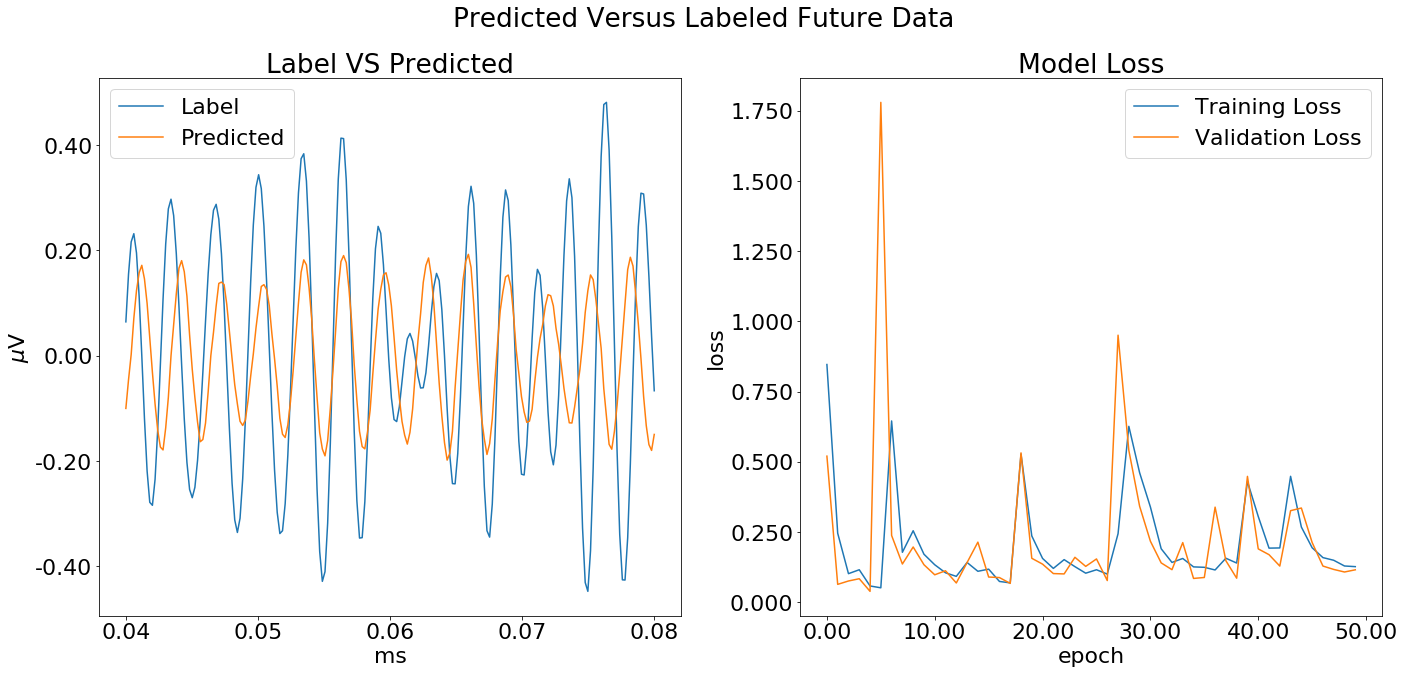

In [17]:
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.linspace(0.04, 0.08, 200)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,:], label='Predicted')
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

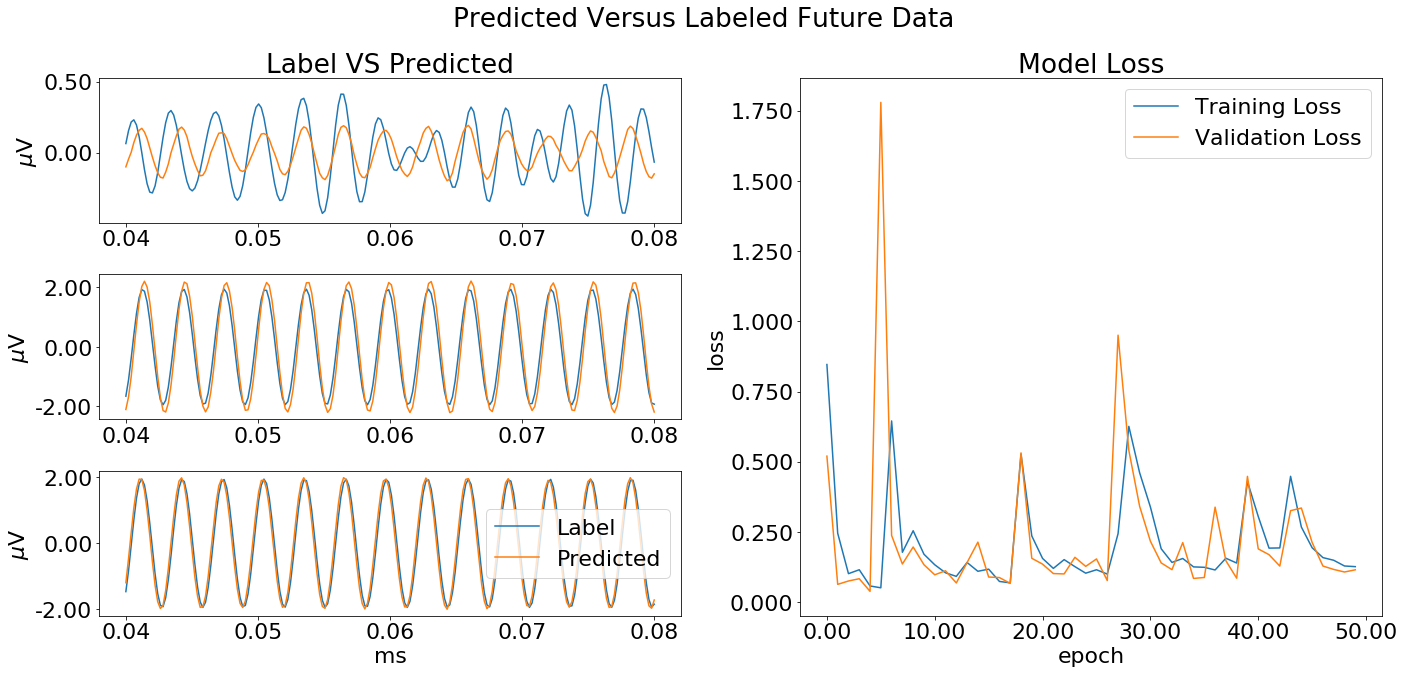

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(3,2)

ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[2,0])
ax2 = fig.add_subplot(gs[:,1])

fig.suptitle('Predicted Versus Labeled Future Data')

t = np.linspace(0.04, 0.08, 200)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,:], label='Predicted')
# ax1.set_ylim([-2.5, 2.5])
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax3.plot(t, y[1,0,:], label='Label')
ax3.plot(t, output[1,:], label='Predicted')
# ax3.set_ylim([-2.5, 2.5])
ax3.set_ylabel(r'$\mu$V')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax4.plot(t, y[2,0,:], label='Label')
ax4.plot(t, output[2,:], label='Predicted')
# ax4.set_ylim([-2.5, 2.5])
ax4.set_xlabel('ms')
ax4.set_ylabel(r'$\mu$V')
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.legend(loc='right')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

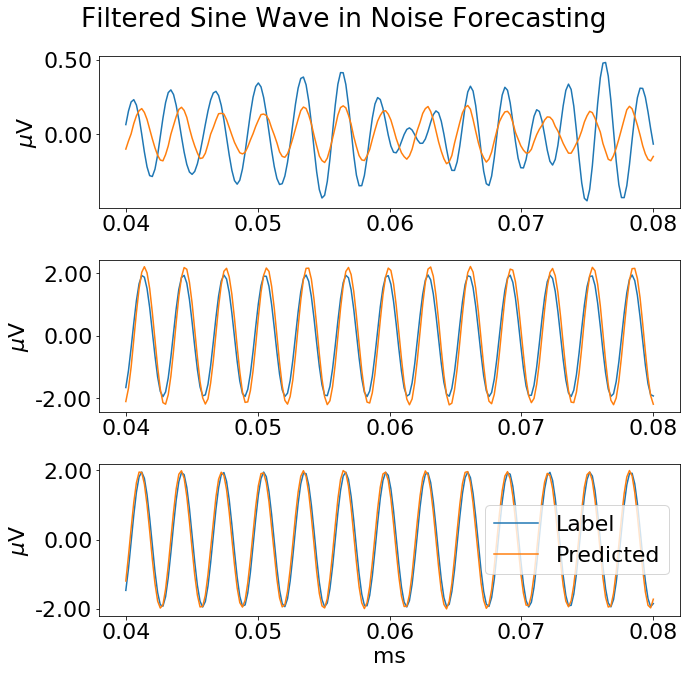

In [20]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(10,10))
gs = GridSpec(3,1)

ax1 = fig.add_subplot(gs[0,0])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[2,0])

fig.suptitle('Filtered Sine Wave in Noise Forecasting')

t = np.linspace(0.04, 0.08, 200)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,:], label='Predicted')
# ax1.set_ylim([-2.5, 2.5])
ax1.set_ylabel(r'$\mu$V')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax3.plot(t, y[1,0,:], label='Label')
ax3.plot(t, output[1,:], label='Predicted')
# ax3.set_ylim([-2.5, 2.5])
ax3.set_ylabel(r'$\mu$V')
ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

ax4.plot(t, y[2,0,:], label='Label')
ax4.plot(t, output[2,:], label='Predicted')
# ax4.set_ylim([-2.5, 2.5])
ax4.set_xlabel('ms')
ax4.set_ylabel(r'$\mu$V')
ax4.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax4.legend(loc='right')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()